In [107]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import optax

jax.config.update("jax_enable_x64", True)
from source.parameter_estimation.training import (
    create_log_params_means_centered_loss_func,
    log_transform_parameters,
    exponentiate_parameters,
)
from scripts.analysis_helper_functions.helper_function_glycolysis_analysis import load_model_glucose_pulse_FF_datasets

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [108]:
expression_data = pd.read_csv("datasets/VanHeerden_Glucose_Pulse/PvanHoekExpressionData.csv", index_col=0)

column_pairs = [
    ("D_HXK", "HXK"),
    ("D_PGI", "PGI"),
    ("D_PFK", "PFK"),
    ("D_FBA", "FBA"),
    ("D_TPI", "TPI"),
    ("D_GAPDH", "GAPDH"),
    ("D_PGK", "PGK"),
    ("D_PGM", "PGM"),
    ("D_ENO", "ENO"),
    ("D_PYK", "PYK"),
    ("D_PDC", "PDC"),
    ("D_ADH", "ADH"),
]

interpolation_expression_dict = {}

Ds = jnp.linspace(0, 0.375, 100)

for D_col, col in column_pairs:
    interp_key = f"expr_interpolated_{col}"
    interpolation_expression_dict[interp_key] = diffrax.LinearInterpolation(
        ts=jnp.array(expression_data[D_col]), ys=jnp.array(expression_data[col])
    )

In [109]:
y0_dict = {
    "ICG1P": 0.064568,
    "ICT6P": 0.093705,
    "ICtreh": 63.312040,
    "ICglucose": 0.196003,
    "ICG6P": 0.716385,
    "ICF6P": 0.202293,
    "ICFBP": 0.057001,
    "ICDHAP": 0.048571,
    "ICG3P": 0.020586,
    "ICglyc": 0.1,
    "ICGAP": 0.006213,
    "ICBPG": 0.0001,
    "IC3PG": 2.311074,
    "IC2PG": 0.297534,
    "ICPEP": 1.171415,
    "ICPYR": 0.152195,
    "ICACE": 0.04,
    "ICETOH": 10.0,
    "ECETOH": 0,
    "ECglycerol": 0.0,
    "ICNADH": 0.0106,
    "ICNAD": 1.5794,
    "ICATP": 3.730584,
    "ICADP": 1.376832,
    "ICAMP": 0.431427,
    "ICPHOS": 10,
    "ICIMP": 0.100,
    "ICINO": 0.100,
    "ICHYP": 1.5,
}

y0 = jnp.array(list(y0_dict.values()))
metabolite_names = list(y0_dict.keys())
params = pd.read_csv(
    "parameter_initializations/Glycolysis_model/parameter_initialization_glycolysis_literature_values.csv", index_col=0
).to_dict()["0"]

In [110]:
glycolyse_GP1, time_points_GP1, y0_GP1, dataset_GP1 = load_model_glucose_pulse_FF_datasets(
    "FF1_timeseries_format.csv", dilution_rate="0.1", y0_dict=y0_dict
)
glycolyse_GP2, time_points_GP2, y0_GP2, dataset_GP2 = load_model_glucose_pulse_FF_datasets(
    "FF2_timeseries_format.csv", dilution_rate="0.1", y0_dict=y0_dict
)
glycolyse_GP3, time_points_GP3, y0_GP3, dataset_GP3 = load_model_glucose_pulse_FF_datasets(
    "FF3_timeseries_format.csv", dilution_rate="0.1", y0_dict=y0_dict
)

In [111]:
log_loss_func_GP1 = jax.jit(create_log_params_means_centered_loss_func(glycolyse_GP1))
log_loss_func_GP2 = jax.jit(create_log_params_means_centered_loss_func(glycolyse_GP2))
log_loss_func_GP3 = jax.jit(create_log_params_means_centered_loss_func(glycolyse_GP3))

In [112]:
datasets = {"GP1": jnp.array(dataset_GP1), "GP2": jnp.array(dataset_GP2), "GP3": jnp.array(dataset_GP3)}

time_points = {"GP1": jnp.array(time_points_GP1), "GP2": jnp.array(time_points_GP2), "GP3": jnp.array(time_points_GP3)}

In [113]:
lr = 1e-3
optimizer = optax.adabelief(lr)
clip_by_global = optax.clip_by_global_norm(np.log(4))
optimizer = optax.chain(optimizer, clip_by_global)
opt_state = optimizer.init(params)
params_init = params

In [114]:
loss_per_iter1 = []
loss_per_iter2 = []
loss_per_iter3 = []

In [115]:
grads_GP1 = jax.jit(jax.grad(log_loss_func_GP1, 0))
grads_GP2 = jax.jit(jax.grad(log_loss_func_GP2, 0))
grads_GP3 = jax.jit(jax.grad(log_loss_func_GP3, 0))

In [166]:
parameters_step_dict = []

In [167]:
ys = datasets
ts = time_points

for step in range(200):
    grads = {}
    log_params = log_transform_parameters(params_init)
    loss1 = log_loss_func_GP1(log_params, ts["GP1"], ys["GP1"])
    grads1 = grads_GP1(log_params, ts["GP1"], ys["GP1"])

    loss2 = log_loss_func_GP2(log_params, ts["GP2"], ys["GP2"])
    grads2 = grads_GP2(log_params, ts["GP2"], ys["GP2"])

    loss3 = log_loss_func_GP3(log_params, ts["GP3"], ys["GP3"])
    grads3 = grads_GP3(log_params, ts["GP3"], ys["GP3"])

    for key in grads1.keys():
        grads[key] = (grads1[key] + grads2[key] + grads3[key]) / 3  # (grads1[key]+grads2[key]+grads3[key])/3

    updates, opt_state = optimizer.update(grads, opt_state)
    # we perform updates in log space, but only return params in lin space
    log_params = optax.apply_updates(log_params, updates)
    lin_params = exponentiate_parameters(log_params)
    params_init = lin_params

    loss_per_iter1.append(float(loss1))
    loss_per_iter2.append(float(loss2))
    loss_per_iter3.append(float(loss3))

    if step % 10 == 0:
        print(f"Step {step}, Loss {loss1+loss2+loss3}")
        parameters_step_dict.append(params_init)

Step 0, Loss 5.644010311247225
Step 10, Loss 5.619382403486485
Step 20, Loss 5.5961207401082955
Step 30, Loss 5.574086505478154
Step 40, Loss 5.553175645209491
Step 50, Loss 5.533288988464566
Step 60, Loss 5.514326725741248
Step 70, Loss 5.4962061452556785
Step 80, Loss 5.478857892968847
Step 90, Loss 5.462210077146742
Step 100, Loss 5.446211632306079
Step 110, Loss 5.43079976857147
Step 120, Loss 5.415924264914618
Step 130, Loss 5.401552626805682
Step 140, Loss 5.387637879739965
Step 150, Loss 5.374146384483615
Step 160, Loss 5.361050430290465
Step 170, Loss 5.348318414728096
Step 180, Loss 5.335922915815053
Step 190, Loss 5.3238406517064885


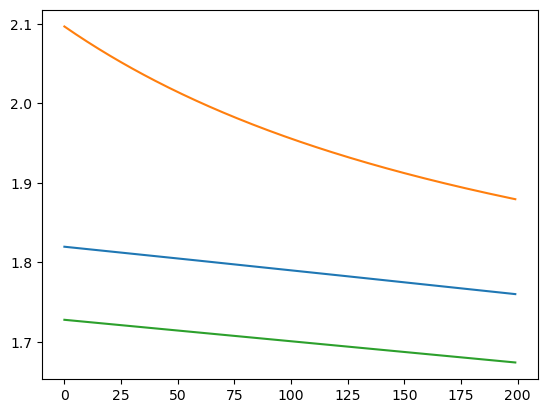

In [168]:
plt.plot(loss_per_iter1[-200:], label="GP1")
plt.plot(loss_per_iter2[-200:], label="GP2")
plt.plot(loss_per_iter3[-200:], label="GP3")

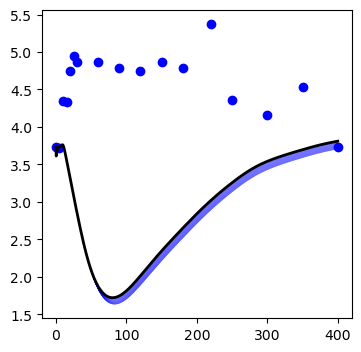

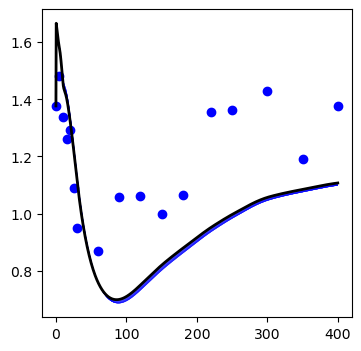

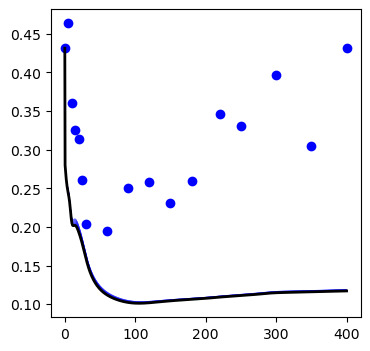

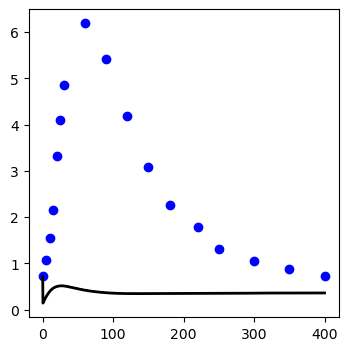

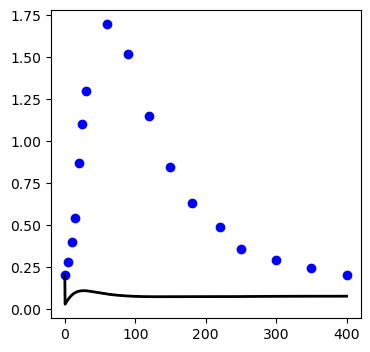

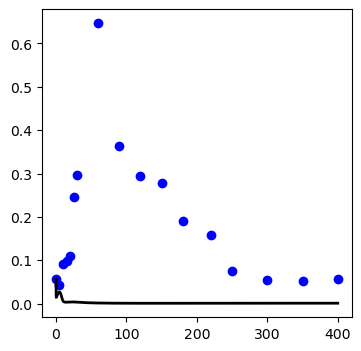

In [170]:
def plot_timeseries(met_name, parameters_step_dict):
    ts_test = jnp.linspace(0, 400, 1000)

    fig, ax = plt.subplots(figsize=(4, 4))
    for i in range(0, len(parameters_step_dict), 1):
        ys = glycolyse_GP1(ts=ts_test, y0=jnp.array(list(y0_GP1.values())), params=parameters_step_dict[i])
        ys = pd.DataFrame(ys, columns=metabolite_names)
        ax.plot(ts_test, ys[met_name], label=met_name, c="blue", linewidth=0.2)

    ys = glycolyse_GP1(ts=ts_test, y0=jnp.array(list(y0_GP1.values())), params=parameters_step_dict[-1])
    ys = pd.DataFrame(ys, columns=metabolite_names)

    ax.plot(ts_test, ys[met_name], label=met_name, c="black", linewidth=2)
    try:
        ax.scatter(time_points_GP1, dataset_GP1[met_name], c="blue")
    except:
        pass
    plt.show()


plot_timeseries("ICATP", parameters_step_dict)
plot_timeseries("ICADP", parameters_step_dict)
plot_timeseries("ICAMP", parameters_step_dict)

plot_timeseries("ICG6P", parameters_step_dict)
plot_timeseries("ICF6P", parameters_step_dict)
plot_timeseries("ICFBP", parameters_step_dict)

In [164]:
plot_timeseries("IC3PG", parameters_step_dict)
# plot_timeseries("IC2PG",parameters_step_dict)

# plot_timeseries("ICFBP",parameters_step_dict)

In [161]:
# parameters_step_dict=pd.DataFrame(parameters_step_dict).to_csv("results/EXP4_Glycolysis_Fitting_Datasets/parameters_during_training_step10.csv")